# crop 된 이미지를 유사한 특성이 가진 1:1 크기의 파일로 변경


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

from tqdm import tqdm

import os
import warnings
warnings.filterwarnings(action='ignore')

In [37]:
def load_image_path(dir):
    food_middle_list = sorted(os.listdir(dir))

    food_list = [] # 음식이름
    food_path_list = [] # 음식이름 경로

    for food_middle in food_middle_list:
        middle_path = os.path.join(dir,food_middle)
        food_name_list = os.listdir(middle_path)

        for food in food_name_list:
            path = os.path.join(middle_path,food)
            food_path_list.append(path)

            name = path.split('/')[-1]
            food_list.append(name)

    return food_list, food_path_list

In [38]:
raw_dir = '/content/drive/MyDrive/project3/data/traindata/kfood'
food_list, food_path_list = load_image_path(raw_dir)
print(len(food_list))
print(food_list)
print(food_path_list)

99
['고등어구이', '갈비구이', '갈치구이', '곱창구이', '닭갈비', '장어구이', '조개구이', '떡갈비', '불고기', '삼겹살', '더덕구이', '조기구이', '황태구이', '훈제오리', '콩나물국', '계란국', '떡국_만두국', '시래기국', '무국', '북엇국', '미역국', '육개장', '과메기', '편육', '콩자반', '양념치킨', '피자', '후라이드치킨', '젓갈', '갓김치', '깍두기', '나박김치', '무생채', '배추김치', '부추김치', '열무김치', '백김치', '총각김치', '오이소박이', '파김치', '가지볶음', '고사리나물', '미역줄기볶음', '숙주나물', '시금치나물', '애호박볶음', '송편', '꿀떡', '경단', '만두', '장', '적', '장아찌', '전', '전골', '조림', '라면', '쫄면', '짬뽕', '물냉면', '짜장면', '비빔냉면', '수제비', '막국수', '잔치국수', '열무국수', '칼국수', '콩국수', '도토리묵', '콩나물무침', '꽈리고추무침', '도라지무침', '잡채', '홍어무침', '회무침', '김밥', '김치볶음밥', '누룽지', '알밥', '비빔밥', '자

In [39]:
food_path_list[0]

'/content/drive/MyDrive/project3/data/traindata/kfood/구이/고등어구이'

In [40]:
def get_all_image_files(directory):
    img_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    image_files = []

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in img_extensions):
                image_files.append(os.path.join(root, file))

    return image_files

/content/drive/MyDrive/project3/data/traindata/kfood/구이/고등어구이/Img_002_0401.jpg


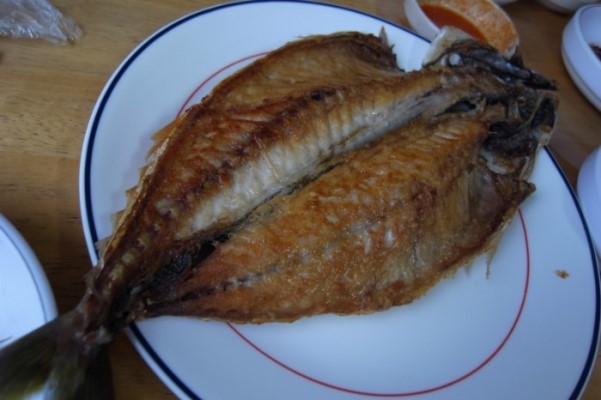

In [41]:
pic_num = 20
test_images = get_all_image_files(food_path_list[0])
test_image = test_images[pic_num]
print(test_image)
cv2_imshow(cv2.imread(test_image))

In [52]:
# histogram 그리기
def calculate_histogram(image):
    # Gray Scale 일떄
    if len(image.shape) == 2:
        histogram = cv2.calcHist([image], # 이미지
                                 [0], # 사용될 채널
                                 None, # 마스크
                                 [256], #bins
                                 [0, 256]) #각 채널의 최소값 / 최대값
    else:  # 컬러 이미지
        histogram = cv2.calcHist([image],
                                 [0, 1, 2],
                                 None,
                                 [256, 256, 256],
                                 [0, 256, 0, 256, 0, 256])

    # 히스토그램 정규화
    cv2.normalize(histogram, histogram)
    return histogram


# 원본과 가장 비슷한 hist를 갖는 그림을 선정
def find_best_match(image, target_hist, patch_size):
    # 가장 비슷한 사이즈를 정하기 위한 준비
    min_diff = float('inf')
    best_x, best_y = 0, 0

    # 이미지 크기
    # Gray Scale 일떄
    if len(image.shape) == 2:
        height, width = image.shape
    # 컬러 이미지
    else:
        height, width, _ = image.shape
    # patch의 위치를 10씩 이동시키며 비교
    for y in range(0, height - patch_size, 10):
        for x in range(0, width - patch_size, 10):
            patch = image[y:y + patch_size, x:x + patch_size]
            patch_hist = calculate_histogram(patch)
            diff = cv2.compareHist(target_hist, patch_hist, cv2.HISTCMP_BHATTACHARYYA)
            if diff < min_diff:
                min_diff = diff
                best_x, best_y = x, y

    return best_x, best_y

def extract_best_patch(image, output_path):

    if len(image.shape) == 2:
        height, width = image.shape
    # 컬러 이미지
    else:
        height, width, _ = image.shape

    patch_size = min(height - 20, width - 20)  # 1:1 비율의 패치 크기 결정(원본보다 20 작게)
    # image = image[:, :, 0]  # 흑백 이미지로 변환
    target_hist = calculate_histogram(image)  # 원본 이미지의 히스토그램 계산

    best_x, best_y = find_best_match(image, target_hist, patch_size)

    # 가장 유사한 패치 추출
    best_patch = image[best_y:best_y + patch_size, best_x:best_x + patch_size]

    # 결과 저장
    # cv2.imwrite(output_path, best_patch)
    # print(f"Best patch saved at {output_path}")

    ## 히스토그램 출력
    # plt.figure()
    # plt.title("Best Patch Histogram")
    # plt.xlabel("Bins")
    # plt.ylabel("# of Pixels")
    # colors = ("b", "g", "r")
    # for i, color in enumerate(colors):
    #     hist = cv2.calcHist([best_patch], [i], None, [256], [0, 256])
    #     plt.plot(hist, color=color)
    #     plt.xlim([0, 256])
    # plt.show()
    return best_patch

원본


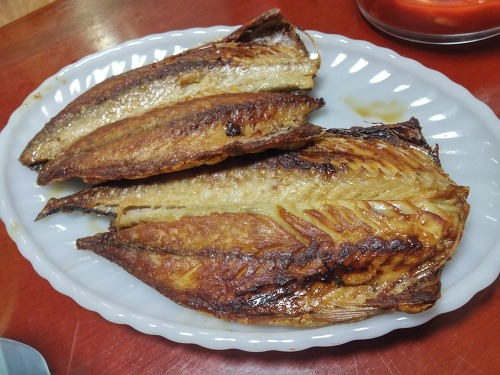

컬러 이미지로 선택


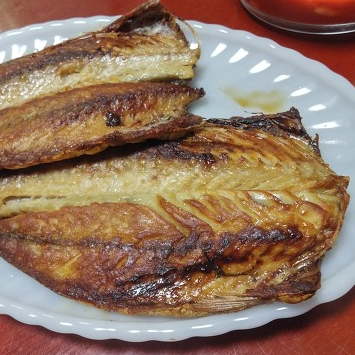

gray 이미지로 선택


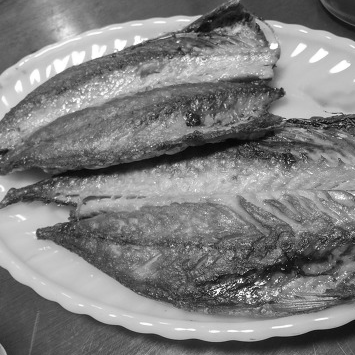

In [53]:
pic_num = 24
test_image_path = test_images[pic_num]
test_image = cv2.imread(test_image_path)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# 원본
print('원본')
cv2_imshow(test_image)
# 컬러 이미지로 선택하기
print('컬러 이미지로 선택')
cv2_imshow(extract_best_patch(test_image, None))
# gray 이미지로 선택하기
print('gray 이미지로 선택')
cv2_imshow(extract_best_patch(test_image_gray, None))

In [51]:
len(test_image_gray.shape)

2